# Using Vision Transformers for Forecasting

In [1]:
from pathlib import Path
import torch

path = Path("/data0/datasets/weatherbench/data/weatherbench")   # replace with path

In [2]:
import xarray as xr

In [3]:
import sys
sys.path.insert(0, '/home/seongbin/climate_tutorial')

In [4]:
path = path/"era5/5.625deg"

In [5]:
!ls {path}

10m_u_component_of_wind  potential_vorticity	       total_cloud_cover
10m_v_component_of_wind  relative_humidity	       total_precipitation
2m_temperature		 specific_humidity	       u_component_of_wind
constants		 temperature		       v_component_of_wind
geopotential		 temperature_850	       vorticity
geopotential_500	 toa_incident_solar_radiation


In [5]:
from climate_tutorial.utils.data import load_dataset, view

t_dataset = load_dataset(path/"temperature_850").drop("level")
z_dataset = load_dataset(path/"geopotential_500").drop("level")
valid_data = xr.merge([t_dataset, z_dataset])
valid_data # view(valid_data) displays valid_data.t2m so it doesn't work

# had to run the following to get this to work:
# !pip install netCDF4 
# !pip install h5netcdf
# !pip install dask

<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 350640)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    t        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-21 05:02:47 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [6]:
from climate_tutorial.utils.datetime import Year, Days, Hours
from climate_tutorial.data import DataModule

data_module = DataModule(
    dataset = "ERA5",
    task = "forecasting",
    root_dir = path,
    in_vars = ["geopotential_500"],
    out_vars = ["geopotential_500"],
    train_start_year = Year(2010), # change
    val_start_year = Year(2015),
    test_start_year = Year(2017),
    end_year = Year(2018),
    pred_range = Days(3),
    subsample = Hours(6),
    batch_size = 32,
    num_workers=16,
)

Creating train dataset


  0%|          | 0/5 [00:00<?, ?it/s]

Creating val dataset


  0%|          | 0/2 [00:00<?, ?it/s]

Creating test dataset


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
from climate_tutorial.models import load_model

def getVitModel(dm, depth=8, decoderdepth=0):
    model_kwargs = {
        "img_size": [32, 64],
        "patch_size": 2,
        "drop_path": 0.1,
        "drop_rate": 0.1,
        "learn_pos_emb": True,
        "in_vars": dm.hparams.in_vars,
        "out_vars": dm.hparams.out_vars,
        "embed_dim": 128,
        "depth": depth,
        "decoder_depth": decoderdepth,
        "num_heads": 4,
        "mlp_ratio": 4,
    }

    optim_kwargs = {
        "lr": 1e-4,
        "weight_decay": 1e-5,
        "warmup_epochs": 1,
        "max_epochs": 5,
    }
    
    return load_model(name = "vit", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

In [8]:
# add_description
from climate_tutorial.models import set_climatology

In [9]:
from climate_tutorial.training import Trainer, WandbLogger

In [11]:
def getTrainer(model_module, dm):
    set_climatology(model_module, dm)
    return Trainer(
        seed = 0,
        accelerator = "gpu",
        precision = 16,
        max_epochs = 5,
#         logger = WandbLogger(project = "climate_tutorial", name = "forecast-vit")
    )

In [12]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [13]:
data_module??

## Training with different depths and decoder depths

In the process of reducing batch size so that the model would fit on the gpu, I realized that smaller batch size (32) had better performance than larger ones (128) for depth 8 and decodder depth 0.

### Depth = 8, Decodder depth = 0

In [14]:
model_module = getVitModel(depth=8, decoderdepth=0, dm=data_module)
trainer = getTrainer(model_module, data_module)
trainer.fit(model_module, data_module)

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     ┃ Name                        ┃ Type              ┃ Params ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0   │ net                         │ VisionTransformer │  1.7 M │
│ 1   │ net.patch_embed             │ PatchEmbed        │    640 │
│ 2   │ net.patch_embed.proj        │ Conv2d            │    640 │
│ 3   │ net.patch_embed.norm        │ Identity          │      0 │
│ 4   │ net.pos_drop                │ Dropout           │      0 │
│ 5   │ net.blocks                  │ ModuleList        │  1.6 M │
│ 6   │ net.blocks.0                │ Block             │  198 K │
│ 7   │ net.blocks.0.norm1          │ LayerNorm         │    256 │
│ 8   │ net.blocks.0.attn           │ Attention         │ 66.0 K │
│ 9   │ net.blocks.0.attn.qkv       │ Linear            │ 49.5 K │
│ 10  │ net.blocks.0.attn.attn_drop │ Dropout           │      0 │
│ 11  │ net.blocks.0.attn.proj      │ Linear            │ 16.5 K │
│ 12  │ net.blocks.0.attn.proj_drop │ Dropout           │      0 │
│ 13  │ net.blocks.0.drop_path      │ Identity          │      0 │
│ 14  │ net.blocks.0.norm2          │ LayerNorm         │    256 │
│ 15  │ net.blocks.0.mlp            │ Mlp               │  131 K │
│ 16  │ net.blocks.0.mlp.fc1        │ Linear            │ 66.0 K │
│ 17  │ net.blocks.0.mlp.act        │ GELU              │      0 │
│ 18  │ net.blocks.0.mlp.drop1      │ Dropout           │      0 │
│ 19  │ net.blocks.0.mlp.fc2        │ Linear            │ 65.7 K │
│ 20  │ net.blocks.0.mlp.drop2      │ Dropout           │      0 │
│ 21  │ net.blocks.1                │ Block             │  198 K │
│ 22  │ net.blocks.1.norm1          │ LayerNorm         │    256 │
│ 23  │ net.blocks.1.attn           │ Attention         │ 66.0 K │
│ 24  │ net.blocks.1.attn.qkv       │ Linear            │ 49.5 K │
│ 25  │ net.blocks.1.attn.attn_drop │ Dropout           │      0 │
│ 26  │ net.blocks.1.attn.proj      │ Linear            │ 16.5 K │
│ 27  │ net.blocks.1.attn.proj_drop │ Dropout           │      0 │
│ 28  │ net.blocks.1.drop_path      │ DropPath          │      0 │
│ 29  │ net.blocks.1.norm2          │ LayerNorm         │    256 │
│ 30  │ net.blocks.1.mlp            │ Mlp               │  131 K │
│ 31  │ net.blocks.1.mlp.fc1        │ Linear            │ 66.0 K │
│ 32  │ net.blocks.1.mlp.act        │ GELU              │      0 │
│ 33  │ net.blocks.1.mlp.drop1      │ Dropout           │      0 │
│ 34  │ net.blocks.1.mlp.fc2        │ Linear            │ 65.7 K │
│ 35  │ net.blocks.1.mlp.drop2      │ Dropout           │      0 │
│ 36  │ net.blocks.2                │ Block             │  198 K │
│ 37  │ net.blocks.2.norm1          │ LayerNorm         │    256 │
│ 38  │ net.blocks.2.attn           │ Attention         │ 66.0 K │
│ 39  │ net.blocks.2.attn.qkv       │ Linear            │ 49.5 K │
│ 40  │ net.blocks.2.attn.attn_drop │ Dropout           │      0 │
│ 41  │ net.blocks.2.attn.proj      │ Linear            │ 16.5 K │
│ 42  │ net.blocks.2.attn.proj_drop │ Dropout           │      0 │
│ 43  │ net.blocks.2.drop_path      │ DropPath          │      0 │
│ 44  │ net.blocks.2.norm2          │ LayerNorm         │    256 │
│ 45  │ net.blocks.2.mlp            │ Mlp               │  131 K │
│ 46  │ net.blocks.2.mlp.fc1        │ Linear            │ 66.0 K │
│ 47  │ net.blocks.2.mlp.act        │ GELU              │      0 │
│ 48  │ net.blocks.2.mlp.drop1      │ Dropout           │      0 │
│ 49  │ net.blocks.2.mlp.fc2        │ Linear            │ 65.7 K │
│ 50  │ net.blocks.2.mlp.drop2      │ Dropout           │      0 │
│ 51  │ net.blocks.3                │ Block             │  198 K │
│ 52  │ net.blocks.3.norm1          │ LayerNorm         │    256 │
│ 53  │ net.blocks.3.attn           │ Attention         │ 66.0 K │
│ 54  │ net.blocks.3.attn.qkv       │ Linear            │ 49.5 K │
│ 55  │ net.blocks.3.attn.attn_drop │ Dropout           │      0 │
│ 56  │ net.blocks.3.attn.proj      │ Linear   

Trainable params: 1.7 M                                                                      
Non-trainable params: 0                                                                      
Total params: 1.7 M                                                                          
Total estimated model params size (MB): 3

Output()

torch.Size([32, 3, 1, 32, 64])

ValueError: too many values to unpack (expected 4)

In [37]:
trainer.validate(model_module, data_module)

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91/91 0:00:04 • 0:00:00 20.78it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Validate metric          ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  val/acc_geopotential_500_day_3   │        0.6238189815507992         │
│   val/acc_temperature_850_day_3   │        0.6619274626036307         │
│ val/w_rmse_geopotential_500_day_3 │         796.6420971428054         │
│ val/w_rmse_temperature_850_day_3  │        3.6401190124655183         │
└───────────────────────────────────┴───────────────────────────────────┘

### Depth = 12, Decodder depth = 0

In [38]:
model_module = getVitModel(depth=12, decoderdepth=0, dm=data_module)
trainer = getTrainer(model_module, data_module)
trainer.fit(model_module, data_module)

Epoch 4/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319/319 0:00:37 • 0:00:00 8.74it/s loss: 0.0598 v_num: kvi8          
                                                                                 train/geopotential_500: 0.062     
                                                                                 train/temperature_850: 0.061      
                                                                                 train/loss: 0.061                 

In [40]:
trainer.validate(model_module, data_module)

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91/91 0:00:06 • 0:00:00 14.87it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Validate metric          ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  val/acc_geopotential_500_day_3   │        0.6239751248523402         │
│   val/acc_temperature_850_day_3   │        0.6695727701605627         │
│ val/w_rmse_geopotential_500_day_3 │         796.0395425029642         │
│ val/w_rmse_temperature_850_day_3  │         3.609795779597761         │
└───────────────────────────────────┴───────────────────────────────────┘

### Depth = 16, Decodder depth = 0

In [42]:
model_module = getVitModel(depth=16, decoderdepth=0, dm=data_module)
trainer = getTrainer(model_module, data_module)
trainer.fit(model_module, data_module)

Epoch 4/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319/319 0:00:47 • 0:00:00 7.29it/s loss: 0.0593 v_num: kvi8          
                                                                                 train/geopotential_500: 0.061     
                                                                                 train/temperature_850: 0.061      
                                                                                 train/loss: 0.061                 

In [43]:
trainer.validate(model_module, data_module)

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91/91 0:00:07 • 0:00:00 11.93it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Validate metric          ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  val/acc_geopotential_500_day_3   │        0.6276690591754734         │
│   val/acc_temperature_850_day_3   │        0.6725657021064215         │
│ val/w_rmse_geopotential_500_day_3 │         791.9158848249613         │
│ val/w_rmse_temperature_850_day_3  │        3.6095534110104115         │
└───────────────────────────────────┴───────────────────────────────────┘

### Depth = 20, Decoder depth = 0

In [55]:
model_module = getVitModel(depth=20, decoderdepth=0, dm=data_module)
trainer = getTrainer(model_module, data_module)
trainer.fit(model_module, data_module)
trainer.validate(model_module, data_module)

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91/91 0:00:09 • 0:00:00 9.85it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Validate metric          ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  val/acc_geopotential_500_day_3   │         0.618503774233087         │
│   val/acc_temperature_850_day_3   │        0.6565179459349924         │
│ val/w_rmse_geopotential_500_day_3 │         798.605911870449          │
│ val/w_rmse_temperature_850_day_3  │        3.6694395375398536         │
└───────────────────────────────────┴───────────────────────────────────┘

### Depth = 32, Decoder depth = 0

In [51]:
model_module = getVitModel(depth=32, decoderdepth=0, dm=data_module)
trainer = getTrainer(model_module, data_module)
trainer.fit(model_module, data_module)

Epoch 4/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319/319 0:01:23 • 0:00:00 4.67it/s loss: 0.0593 v_num: kvi8          
                                                                                 train/geopotential_500: 0.062     
                                                                                 train/temperature_850: 0.06       
                                                                                 train/loss: 0.061                 

In [52]:
trainer.validate(model_module, data_module)

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91/91 0:00:14 • 0:00:00 6.39it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Validate metric          ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  val/acc_geopotential_500_day_3   │        0.6210582110772069         │
│   val/acc_temperature_850_day_3   │        0.6651267914303869         │
│ val/w_rmse_geopotential_500_day_3 │         795.351203631581          │
│ val/w_rmse_temperature_850_day_3  │         3.645674099560679         │
└───────────────────────────────────┴───────────────────────────────────┘

### Depth = 8, Decoder depth = 2

In [45]:
model_module = getVitModel(depth=8, decoderdepth=2, dm=data_module)
trainer = getTrainer(model_module, data_module)
trainer.fit(model_module, data_module)

Epoch 4/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319/319 0:00:24 • 0:00:00 13.24it/s loss: 0.0598 v_num: kvi8          
                                                                                 train/geopotential_500: 0.061     
                                                                                 train/temperature_850: 0.06       
                                                                                 train/loss: 0.061                 

In [46]:
trainer.validate(model_module, data_module)

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91/91 0:00:04 • 0:00:00 20.86it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Validate metric          ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  val/acc_geopotential_500_day_3   │        0.6043271639843941         │
│   val/acc_temperature_850_day_3   │        0.6657759516448787         │
│ val/w_rmse_geopotential_500_day_3 │         814.6243067291224         │
│ val/w_rmse_temperature_850_day_3  │         3.647666490465366         │
└───────────────────────────────────┴───────────────────────────────────┘

### Depth = 16, Decoder depth = 2

In [47]:
model_module = getVitModel(depth=16, decoderdepth=2, dm=data_module)
trainer = getTrainer(model_module, data_module)
trainer.fit(model_module, data_module)

Epoch 4/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319/319 0:00:47 • 0:00:00 7.21it/s loss: 0.0589 v_num: kvi8          
                                                                                 train/geopotential_500: 0.061     
                                                                                 train/temperature_850: 0.059      
                                                                                 train/loss: 0.06                  

In [48]:
trainer.validate(model_module, data_module)

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91/91 0:00:07 • 0:00:00 11.77it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Validate metric          ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  val/acc_geopotential_500_day_3   │        0.6044709585906413         │
│   val/acc_temperature_850_day_3   │        0.6712572682489094         │
│ val/w_rmse_geopotential_500_day_3 │         811.9827194059685         │
│ val/w_rmse_temperature_850_day_3  │        3.6128170251385323         │
└───────────────────────────────────┴───────────────────────────────────┘

### Depth = 20, Decoder Depth = 2

In [56]:
model_module = getVitModel(depth=20, decoderdepth=2, dm=data_module)
trainer = getTrainer(model_module)
trainer.fit(model_module, data_module)
trainer.validate(model_module, data_module)

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91/91 0:00:09 • 0:00:00 9.86it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Validate metric          ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  val/acc_geopotential_500_day_3   │        0.6080528576029823         │
│   val/acc_temperature_850_day_3   │        0.6680510594135566         │
│ val/w_rmse_geopotential_500_day_3 │         811.2213598651499         │
│ val/w_rmse_temperature_850_day_3  │         3.641901243566519         │
└───────────────────────────────────┴───────────────────────────────────┘

### Depth = 32, Decodder depth = 2

In [49]:
model_module = getVitModel(depth=32, decoderdepth=2, dm=data_module)
trainer = getTrainer(model_module, data_module)
trainer.fit(model_module, data_module)

Epoch 4/4  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319/319 0:01:24 • 0:00:00 4.68it/s loss: 0.0585 v_num: kvi8          
                                                                                 train/geopotential_500: 0.06      
                                                                                 train/temperature_850: 0.059      
                                                                                 train/loss: 0.06                  

In [50]:
trainer.validate(model_module, data_module)

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91/91 0:00:14 • 0:00:00 6.41it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Validate metric          ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  val/acc_geopotential_500_day_3   │        0.6065627836168659         │
│   val/acc_temperature_850_day_3   │        0.6651661661303583         │
│ val/w_rmse_geopotential_500_day_3 │         807.5290027104866         │
│ val/w_rmse_temperature_850_day_3  │        3.6473476395080784         │
└───────────────────────────────────┴───────────────────────────────────┘

### Results

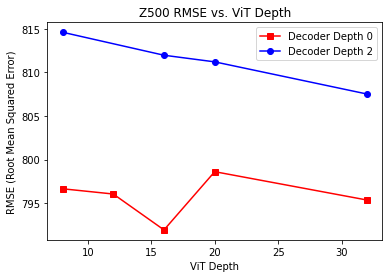

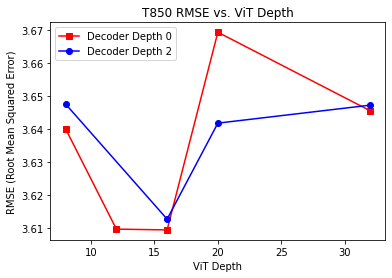

In [58]:
depth0 = [8, 12, 16, 20, 32]
depth2 = [8, 16, 20, 32]
z500_rmse_0 = [796.6420971428054, 796.0395425029642, 791.9158848249613, 798.605911870449, 795.351203631581]
t830_rmse_0 = [3.6401190124655183, 3.609795779597761, 3.6095534110104115, 3.6694395375398536, 3.645674099560679]

z500_rmse_2 = [814.6243067291224, 811.9827194059685 , 811.2213598651499, 807.5290027104866,]
t830_rmse_2 = [3.647666490465366, 3.6128170251385323, 3.641901243566519, 3.6473476395080784]


import matplotlib.pyplot as plt
# z500 rmse plot
plt.plot(depth0, z500_rmse_0, 'rs-', depth2, z500_rmse_2, 'bo-', )
plt.xlabel("ViT Depth")
plt.ylabel("RMSE (Root Mean Squared Error)")
plt.title("Z500 RMSE vs. ViT Depth")
plt.legend(("Decoder Depth 0", "Decoder Depth 2"))
plt.show()

# t850 rmse plot
plt.plot(depth0, t830_rmse_0, 'rs-', depth2, t830_rmse_2, 'bo-', )
plt.xlabel("ViT Depth")
plt.ylabel("RMSE (Root Mean Squared Error)")
plt.title("T850 RMSE vs. ViT Depth")
plt.legend(("Decoder Depth 0", "Decoder Depth 2"))
plt.show()

## Using separate models for z500 and t850

In [59]:
z500_data_module = DataModule(
    dataset = "ERA5",
    task = "forecasting",
    root_dir = path,
    in_vars = ["geopotential_500"],
    out_vars = ["geopotential_500"],
    train_start_year = Year(2010), # changed from 1979
    val_start_year = Year(2015),
    test_start_year = Year(2017),
    end_year = Year(2018),
    pred_range = Days(3),
    subsample = Hours(6),
    batch_size = 32,
    num_workers=16,
)

t_850_data_module = DataModule(
    dataset = "ERA5",
    task = "forecasting",
    root_dir = path,
    in_vars = ["temperature_850"],
    out_vars = ["temperature_850"],
    train_start_year = Year(2010), # changed from 1979
    val_start_year = Year(2015),
    test_start_year = Year(2017),
    end_year = Year(2018),
    pred_range = Days(3),
    subsample = Hours(6),
    batch_size = 32,
    num_workers=16,
)

Creating train dataset


  0%|          | 0/5 [00:00<?, ?it/s]

Creating val dataset


  0%|          | 0/2 [00:00<?, ?it/s]

Creating test dataset


  0%|          | 0/2 [00:00<?, ?it/s]

Creating train dataset


  0%|          | 0/5 [00:00<?, ?it/s]

Creating val dataset


  0%|          | 0/2 [00:00<?, ?it/s]

Creating test dataset


  0%|          | 0/2 [00:00<?, ?it/s]

In [66]:
model_module = getVitModel(depth=16, decoderdepth=0, dm=z500_data_module)
trainer = getTrainer(model_module, z500_data_module)
trainer.fit(model_module, z500_data_module)
trainer.validate(model_module, z500_data_module)

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91/91 0:00:04 • 0:00:00 21.34it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Validate metric          ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  val/acc_geopotential_500_day_3   │        0.6230842003737803         │
│ val/w_rmse_geopotential_500_day_3 │         796.5251468007451         │
└───────────────────────────────────┴───────────────────────────────────┘

In [68]:
model_module = getVitModel(depth=16, decoderdepth=0, dm=t_850_data_module)
trainer = getTrainer(model_module, t_850_data_module)
trainer.fit(model_module, t_850_data_module)
trainer.validate(model_module, t_850_data_module)

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91/91 0:00:04 • 0:00:00 21.16it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Validate metric          ┃           DataLoader 0           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  val/acc_temperature_850_day_3   │        0.6455648656885067        │
│ val/w_rmse_temperature_850_day_3 │        3.7202589539174613        │
└──────────────────────────────────┴──────────────────────────────────┘

No big difference, or even worse.

## Training Full Model

In [ ]:
data_module = DataModule(
    dataset = "ERA5",
    task = "forecasting",
    root_dir = path,
    in_vars = ["geopotential_500", "temperature_850"],
    out_vars = ["geopotential_500", "temperature_850"],
    train_start_year = Year(1979), # change
    val_start_year = Year(2015),
    test_start_year = Year(2017),
    end_year = Year(2018),
    pred_range = Days(3),
    subsample = Hours(6),
    batch_size = 32,
    num_workers=16,
)

model_kwargs = {
    "img_size": [32, 64],
    "patch_size": 2,
    "drop_path": 0.1,
    "drop_rate": 0.1,
    "learn_pos_emb": True,
    "in_vars": data_module.hparams.in_vars,
    "out_vars": data_module.hparams.out_vars,
    "embed_dim": 128,
    "depth": 16,
    "decoder_depth": 0,
    "num_heads": 4,
    "mlp_ratio": 4,
}

optim_kwargs = {
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 50,
}

model_module = load_model(name = "vit", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

set_climatology(model_module, data_module)
trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 50,
    logger = WandbLogger(project = "climate_tutorial", name = "forecast-vit")
)

trainer.fit(model_module, data_module)
trainer.test(model_module, data_module)

Epoch 11/49 ━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━ 1258/1735 0:03:29 • 0:01:17 6.22it/s loss: 0.0444 v_num: kvi8         
                                                                                  train/geopotential_500: 0.046    
                                                                                  train/temperature_850: 0.043     
                                                                                  train/loss: 0.045                

In [ ]:
## Todos
- better functions